<a href="https://colab.research.google.com/github/ben45123/AWS-Lambda-Research/blob/main/ComputerVisionProjectPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import shutil

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


Path to dataset files: /kaggle/input/oily-dry-and-normal-skin-types-dataset
Contents of the dataset directory:
['Oily-Dry-Skin-Types']
Contents of Oily-Dry-Skin-Types directory: ['README.dataset.txt', 'valid', 'test', 'train']
Found directories - Train: True, Test: True, Validation: True
Train subdirectories: ['dry', 'normal', 'oily']
  dry: 652 images
  normal: 1104 images
  oily: 1000 images
Validation subdirectories: ['dry', 'normal', 'oily']
  dry: 71 images
  normal: 111 images
  oily: 80 images
Test subdirectories: ['dry', 'normal', 'oily']
  dry: 35 images
  normal: 59 images
  oily: 40 images


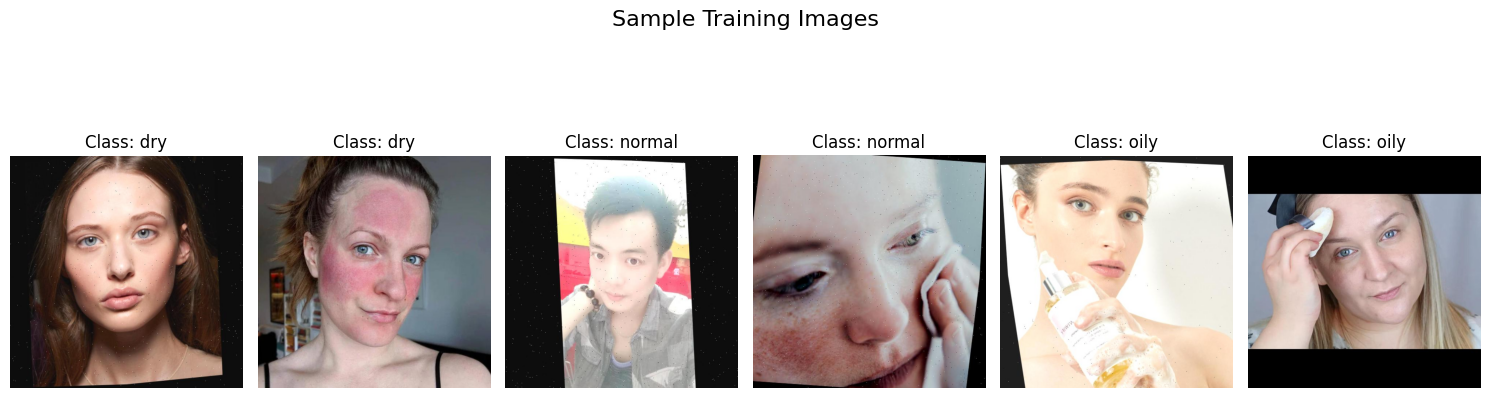

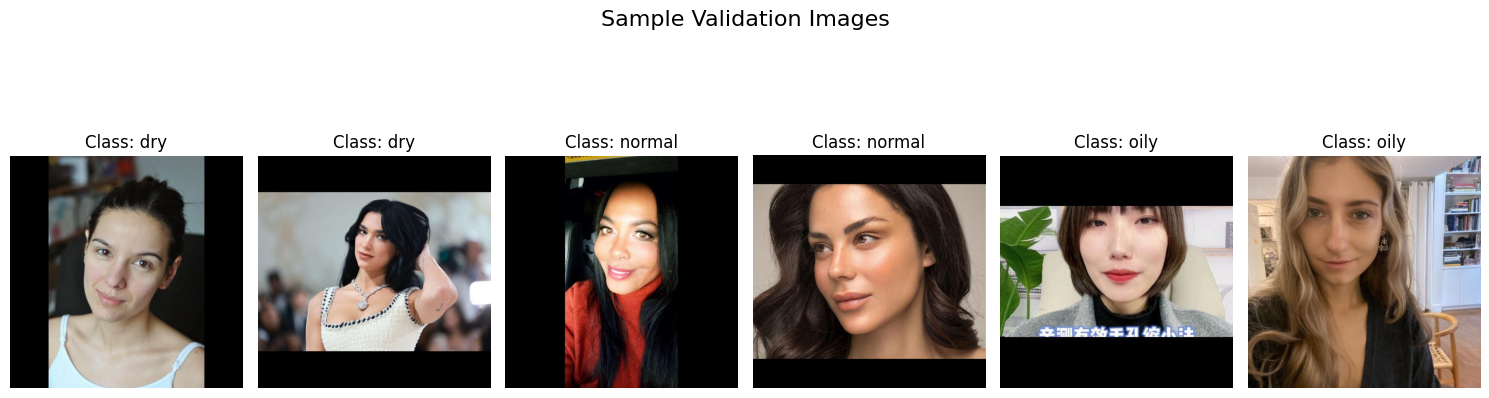

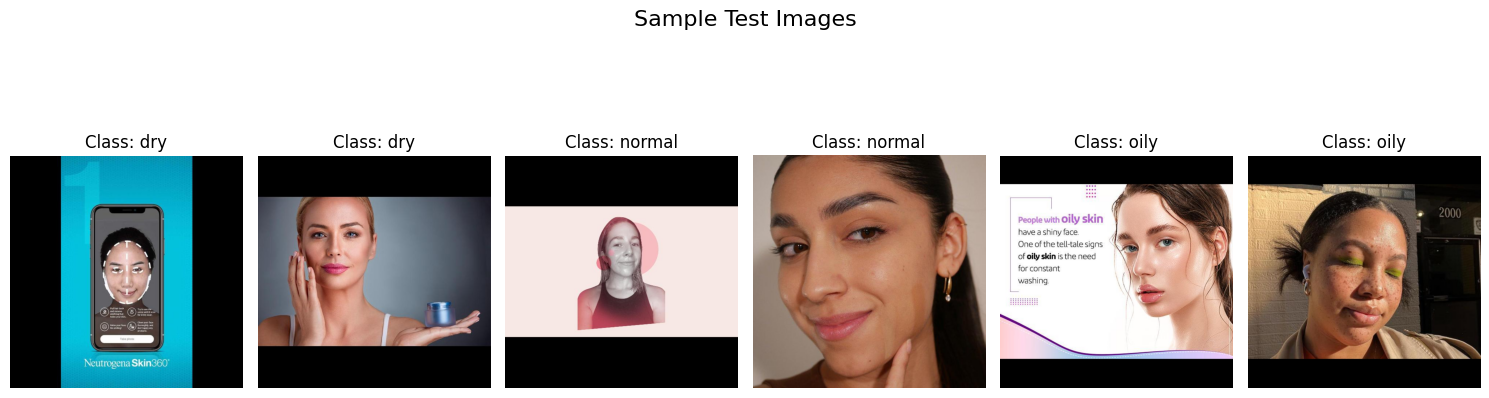

In [2]:
# Cell 2: Set Configuration Parameters for Skin Type Model
import kagglehub
import os
import matplotlib.pyplot as plt
import cv2
import random

# Download dataset
path = kagglehub.dataset_download("shakyadissanayake/oily-dry-and-normal-skin-types-dataset")
print("Path to dataset files:", path)

# Let's examine the directory structure
print("Contents of the dataset directory:")
dataset_contents = os.listdir(path)
print(dataset_contents)

# We have an additional level of nesting
data_dir = os.path.join(path, "Oily-Dry-Skin-Types")
if os.path.exists(data_dir):
    nested_contents = os.listdir(data_dir)
    print(f"Contents of Oily-Dry-Skin-Types directory: {nested_contents}")

    # Now check for train, test, valid
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")
    valid_dir = os.path.join(data_dir, "valid")  # Dataset might use 'valid' instead of 'validation'

    # Check if these directories exist
    train_exists = os.path.exists(train_dir)
    test_exists = os.path.exists(test_dir)
    valid_exists = os.path.exists(valid_dir)

    print(f"Found directories - Train: {train_exists}, Test: {test_exists}, Validation: {valid_exists}")

    # Check contents of each directory
    if train_exists:
        train_subdirs = os.listdir(train_dir)
        print(f"Train subdirectories: {train_subdirs}")
        for subdir in train_subdirs:
            subdir_path = os.path.join(train_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    if valid_exists:
        valid_subdirs = os.listdir(valid_dir)
        print(f"Validation subdirectories: {valid_subdirs}")
        for subdir in valid_subdirs:
            subdir_path = os.path.join(valid_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    if test_exists:
        test_subdirs = os.listdir(test_dir)
        print(f"Test subdirectories: {test_subdirs}")
        for subdir in test_subdirs:
            subdir_path = os.path.join(test_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    # Configuration
    IMG_SIZE = 224  # Standard input size for MobileNetV2
    BATCH_SIZE = 32
    EPOCHS = 15
    NUM_CLASSES = 3  # Oily, Dry, Normal
    CLASS_NAMES = ['Dry', 'Normal', 'Oily']  # Using capitalized version for consistency

    # Set paths to use the existing directory structure
    TRAIN_DIR = train_dir if train_exists else None
    VAL_DIR = valid_dir if valid_exists else None
    TEST_DIR = test_dir if test_exists else None

    # Create output directory for saving model checkpoints
    OUTPUT_DIR = "./models/skin_type/"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Display sample images from each set
    def display_sample_images(directory, title, samples_per_class=2):
        """Display sample images from the dataset directory structure"""
        if directory is None:
            print(f"Cannot display {title} - directory not found")
            return

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)

        all_samples = []

        # Get sample images from each class
        for i, class_name in enumerate(['dry', 'normal', 'oily']):
            class_dir = os.path.join(directory, class_name)
            if os.path.exists(class_dir):
                images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
                if images:
                    samples = random.sample(images, min(samples_per_class, len(images)))
                    for sample in samples:
                        img_path = os.path.join(class_dir, sample)
                        all_samples.append((img_path, class_name))

        # Display up to 6 images
        for i, (img_path, class_name) in enumerate(all_samples[:6]):
            plt.subplot(1, 6, i+1)
            try:
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f'Class: {class_name}')
                plt.axis('off')
            except Exception as e:
                print(f"Error displaying image {img_path}: {e}")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Sample a few images from each split
    try:
        if TRAIN_DIR:
            display_sample_images(TRAIN_DIR, 'Sample Training Images')
        if VAL_DIR:
            display_sample_images(VAL_DIR, 'Sample Validation Images')
        if TEST_DIR:
            display_sample_images(TEST_DIR, 'Sample Test Images')
    except Exception as e:
        print(f"Error displaying sample images: {e}")
else:
    print("Oily-Dry-Skin-Types directory not found. Please check the dataset structure.")

In [3]:
# Cell 3: Set Up Data Generators with Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and testing, we only rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators - using lowercase class names to match the directory structure
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices and print them
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Update CLASS_NAMES based on actual class indices
CLASS_NAMES = list(class_indices.keys())
print("Class names from generator:", CLASS_NAMES)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Class indices: {'dry': 0, 'normal': 1, 'oily': 2}
Class names from generator: ['dry', 'normal', 'oily']


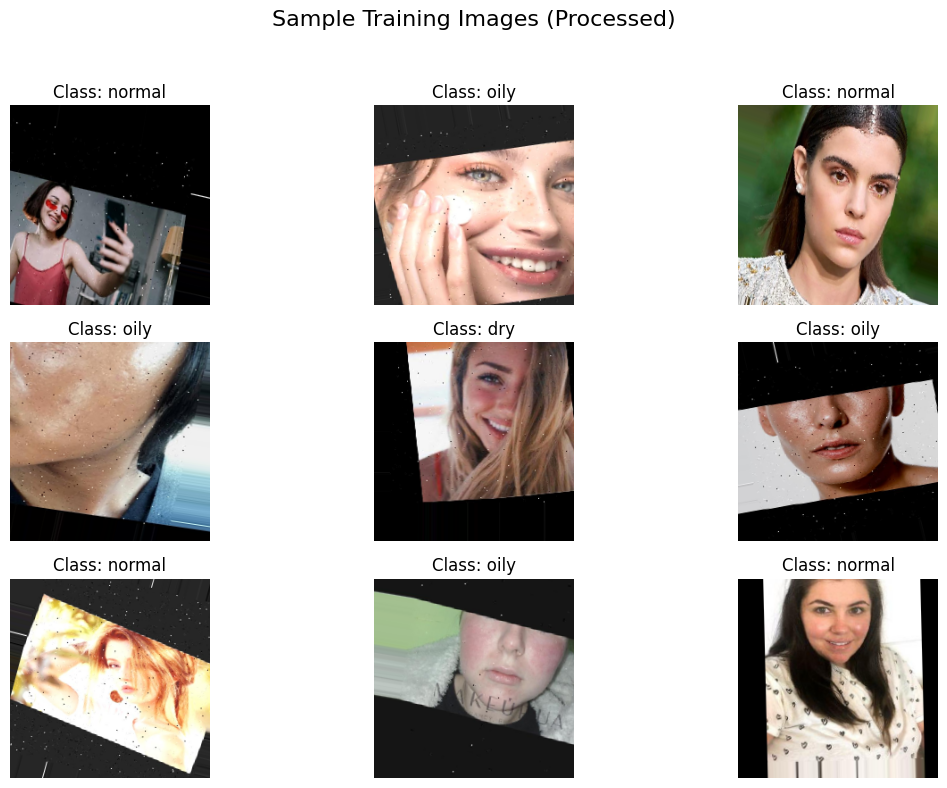

In [4]:
# Cell 4: Visualize Sample Images from the Data Generator
import numpy as np

def display_sample_images_from_generator(generator, title):
    """
    Display sample images from a data generator.

    Args:
        generator: Data generator
        title: Title for the plot
    """
    # Get a batch of images
    x_batch, y_batch = next(generator)

    # Create a figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)

    # Display up to 9 images from the batch
    for i in range(min(9, len(x_batch))):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        class_name = list(class_indices.keys())[class_idx]
        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display sample images from training set
display_sample_images_from_generator(train_generator, 'Sample Training Images (Processed)')

In [5]:
# Cell 5: Enhanced Face Detection Preprocessing Functions
def detect_face_improved(image, expand_factor=0.2):
    """
    Enhanced face detection with better parameters and face region expansion.

    Args:
        image: Input image (BGR format from OpenCV)
        expand_factor: Factor to expand the face region (percentage of face size)

    Returns:
        Face region if found, otherwise the original image with a flag indicating if face was found
    """
    # Load pre-trained face detector from OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert to grayscale for face detection
    if len(image.shape) == 3:  # Color image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Already grayscale
        gray = image

    # Detect faces with adjusted parameters for better detection
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # If faces are found, return the expanded first face region
    if len(faces) > 0:
        x, y, w, h = faces[0]

        # Calculate expanded region
        expand_x = int(w * expand_factor)
        expand_y = int(h * expand_factor)

        # Calculate new coordinates with bounds checking
        new_x = max(0, x - expand_x)
        new_y = max(0, y - expand_y)
        new_w = min(image.shape[1] - new_x, w + 2 * expand_x)
        new_h = min(image.shape[0] - new_y, h + 2 * expand_y)

        # Extract expanded face region
        face_region = image[new_y:new_y+new_h, new_x:new_x+new_w]
        return face_region, True
    else:
        # If no face is detected, return the original image
        return image, False

def preprocess_image_improved(image_path, target_size=(IMG_SIZE, IMG_SIZE), crop_center=True):
    """
    Enhanced preprocessing with better face detection and fallback to center crop.

    Args:
        image_path: Path to the image file
        target_size: Target size for model input
        crop_center: If True and no face is detected, crop the center of the image

    Returns:
        Preprocessed image ready for model input and a flag indicating if face was detected
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Detect face
    face, face_detected = detect_face_improved(image)

    # If no face detected and crop_center is True, crop the center section
    if not face_detected and crop_center:
        h, w = image.shape[:2]
        # Determine the dimension to crop from (the larger one)
        crop_size = min(h, w)
        # Calculate crop coordinates to get the center
        start_y = (h - crop_size) // 2
        start_x = (w - crop_size) // 2
        # Crop the center square
        face = image[start_y:start_y+crop_size, start_x:start_x+crop_size]

    # Resize to target size
    face_resized = cv2.resize(face, target_size)

    # Convert BGR to RGB (TensorFlow uses RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to [0, 1]
    face_normalized = face_rgb / 255.0

    return face_normalized, face_detected


In [13]:
# Cell 6: Fixed Custom Data Generator with Face Detection
class FaceDetectionSequence(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, class_mode='categorical', shuffle=True, augment=False):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.augment = augment

        # Find all image paths and their classes
        self.image_paths = []
        self.labels = []

        # Get class names from directory
        self.class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.class_indices = {cls: i for i, cls in enumerate(self.class_names)}

        # Collect all image paths and labels
        for class_name in self.class_names:
            class_dir = os.path.join(directory, class_name)
            if os.path.isdir(class_dir):
                class_images = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)
                                if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))]
                self.image_paths.extend(class_images)
                self.labels.extend([self.class_indices[class_name]] * len(class_images))

        # Convert to numpy arrays
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels)

        # Create indices array
        self.indices = np.arange(len(self.image_paths))

        # Shuffle data initially if required
        if self.shuffle:
            np.random.shuffle(self.indices)

        # Create augmentation generator if required
        if self.augment:
            self.augmentor = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Initialize batch arrays
        batch_x = np.zeros((len(batch_indices), self.target_size[0], self.target_size[1], 3), dtype=np.float32)

        # For categorical
        if self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_indices), len(self.class_names)), dtype=np.float32)
        else:
            batch_y = np.zeros((len(batch_indices),), dtype=np.float32)

        # Process each image in the batch
        for i, idx in enumerate(batch_indices):
            try:
                # Get image path and label
                img_path = self.image_paths[idx]
                label = self.labels[idx]

                # Apply face detection and preprocessing
                img, _ = preprocess_image_improved(img_path, self.target_size)

                # Store in batch
                batch_x[i] = img

                # One-hot encode the class for categorical
                if self.class_mode == 'categorical':
                    batch_y[i, label] = 1
                else:
                    batch_y[i] = label

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                # Use zeros for failures but keep label
                if self.class_mode == 'categorical':
                    batch_y[i, label] = 1
                else:
                    batch_y[i] = label

        # Apply augmentations if specified
        if self.augment:
            for i in range(len(batch_x)):
                # Add batch dimension for augmentation
                img = np.expand_dims(batch_x[i], 0)
                # Generate a random transformation
                transform_parameters = self.augmentor.get_random_transform(img.shape[1:3])
                # Apply the transformation
                batch_x[i] = self.augmentor.apply_transform(img[0], transform_parameters)

        return batch_x, batch_y

    def on_epoch_end(self):
        # Shuffle indices after each epoch if required
        if self.shuffle:
            np.random.shuffle(self.indices)

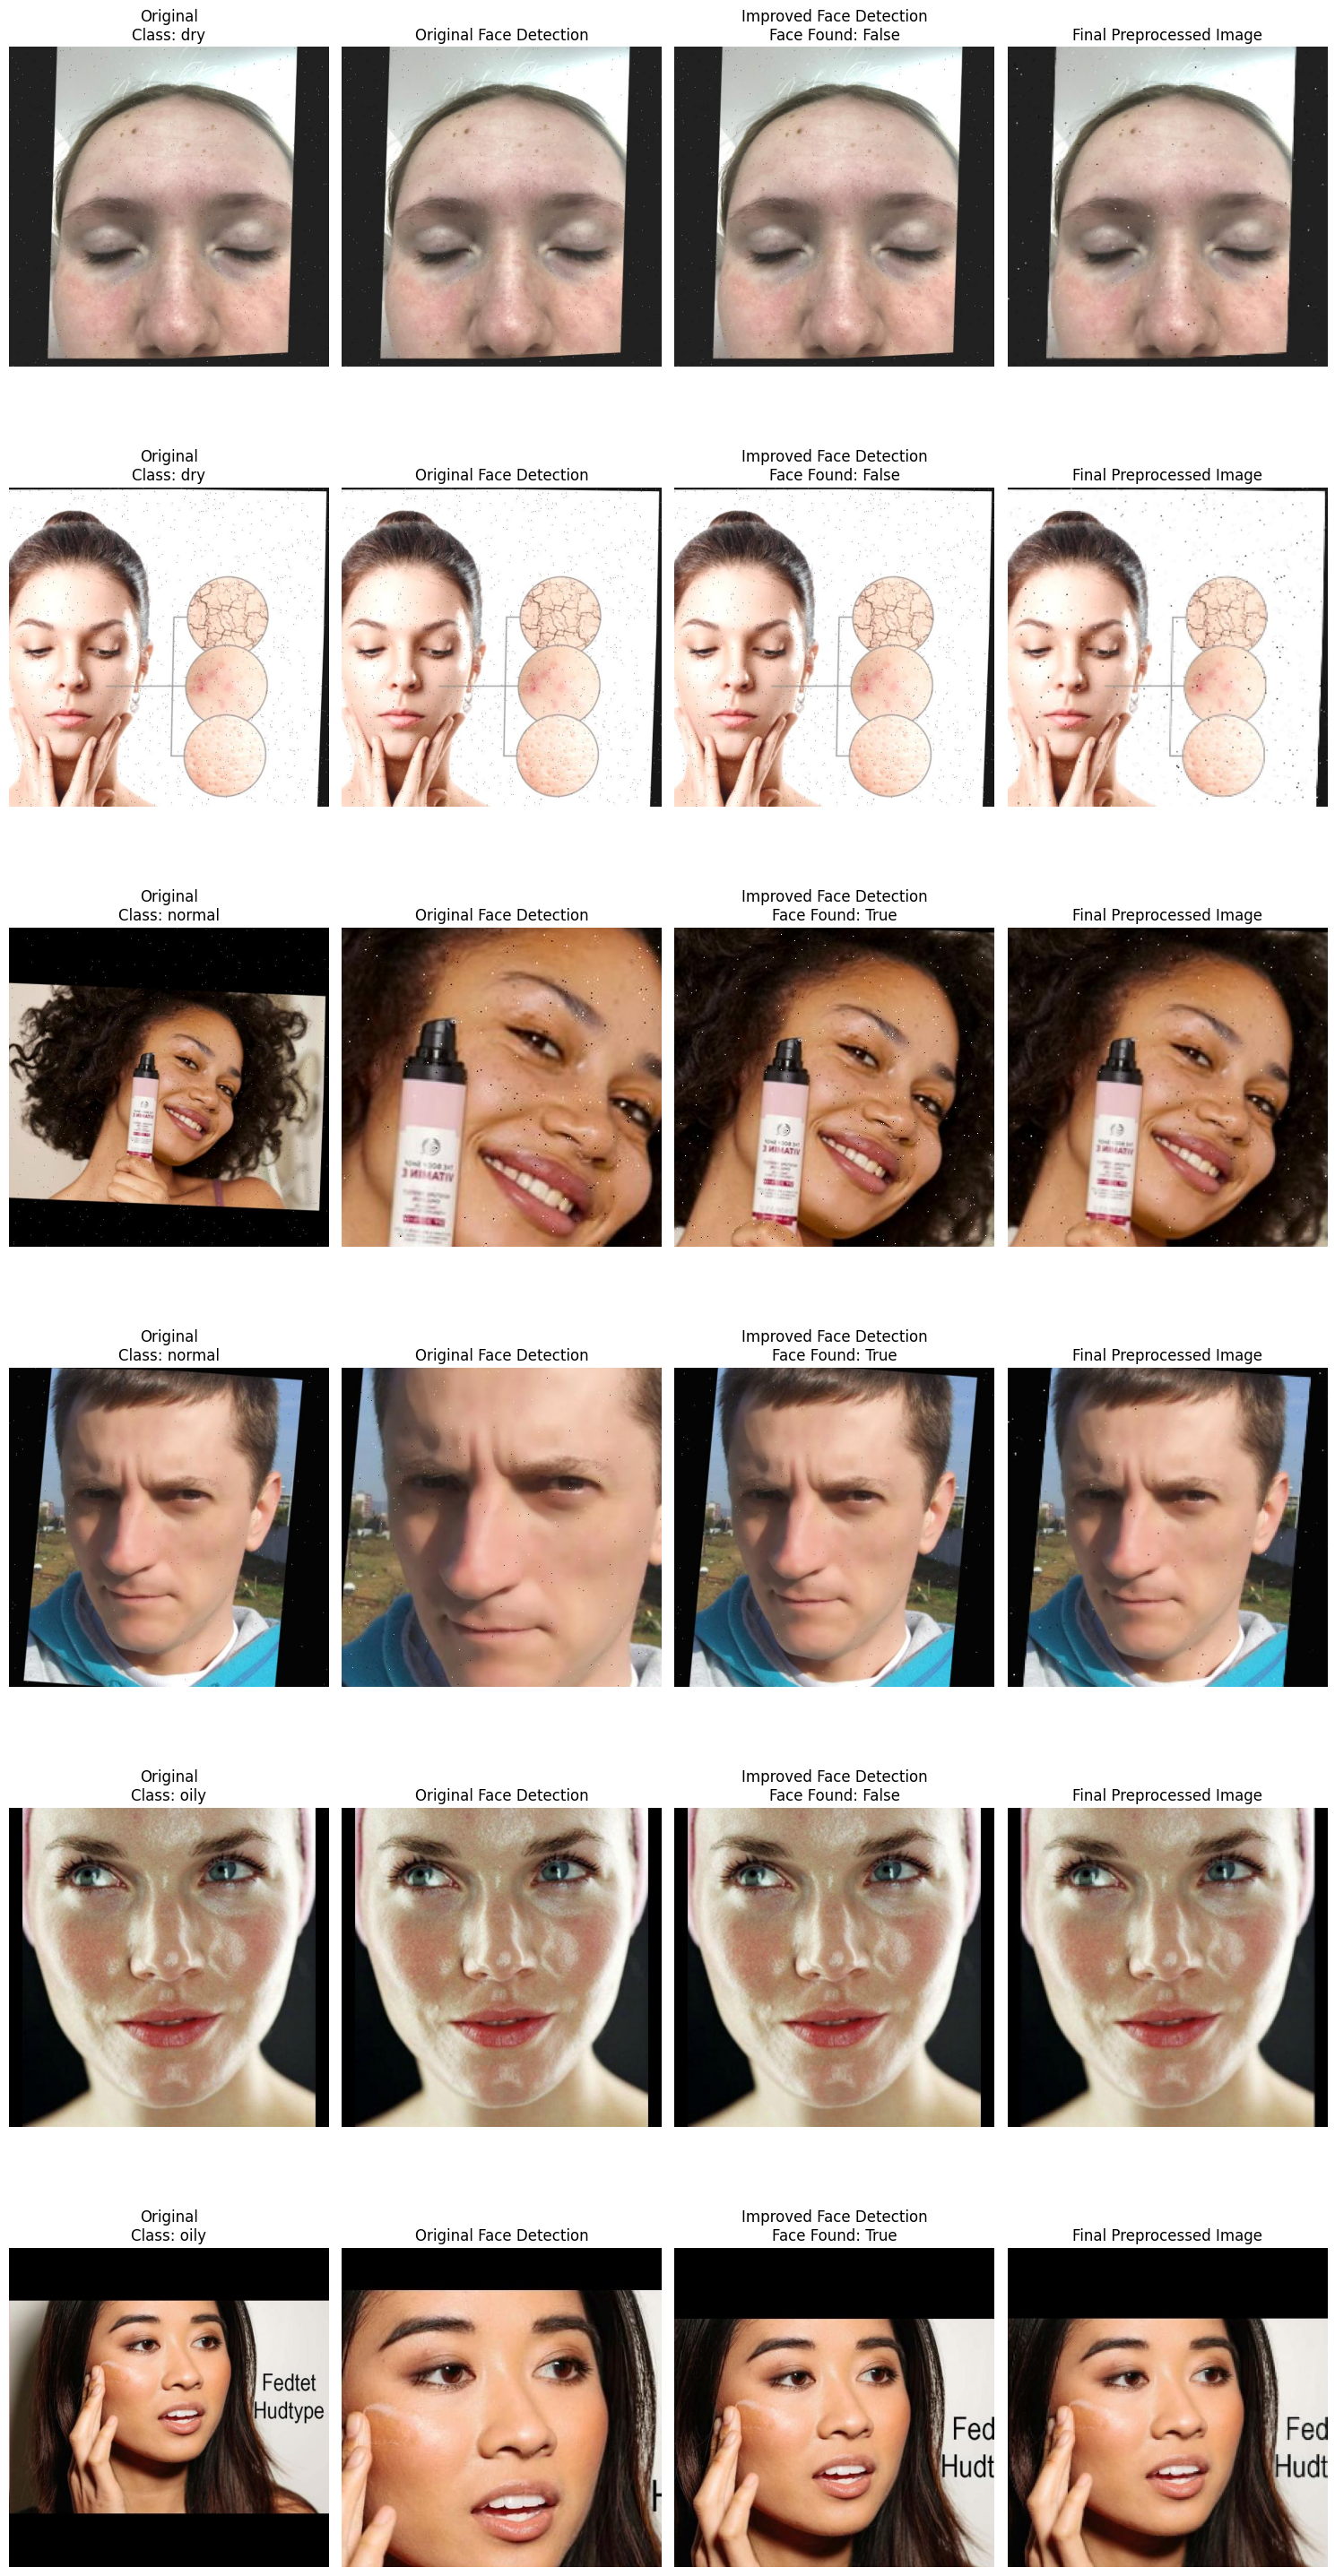

In [14]:
# Cell 7: Test and Visualize Face Detection (Fixed)
def test_face_detection():
    """
    Test face detection on sample images from the dataset.
    """
    # Since detect_face is not defined, let's use the one from Cell 5 in the original notebook
    def detect_face(image):
        """
        Detect face in an image and return the face region.
        Args:
            image: Input image (BGR format from OpenCV)
        Returns:
            Face region if found, otherwise the original image
        """
        # Load pre-trained face detector from OpenCV
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # If faces are found, return the first face region
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_region = image[y:y+h, x:x+w]
            return face_region
        else:
            # If no face is detected, return the original image
            return image

    # Collect sample images from each class
    sample_images = []
    for class_name in ['dry', 'normal', 'oily']:
        class_dir = os.path.join(TRAIN_DIR, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
            if image_files:
                selected = random.sample(image_files, min(2, len(image_files)))
                for img in selected:
                    sample_images.append((os.path.join(class_dir, img), class_name))

    # Display face detection results
    plt.figure(figsize=(15, 5 * len(sample_images)))

    for i, (img_path, class_name) in enumerate(sample_images):
        # Load original image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect face with original method
        original_face = detect_face(img)
        original_face_rgb = cv2.cvtColor(original_face, cv2.COLOR_BGR2RGB)

        # Detect face with improved method
        improved_face, face_detected = detect_face_improved(img)
        improved_face_rgb = cv2.cvtColor(improved_face, cv2.COLOR_BGR2RGB)

        # Create final preprocessed image
        preprocessed, _ = preprocess_image_improved(img_path)

        # Display results
        plt.subplot(len(sample_images), 4, i*4+1)
        plt.imshow(img_rgb)
        plt.title(f'Original\nClass: {class_name}')
        plt.axis('off')

        plt.subplot(len(sample_images), 4, i*4+2)
        plt.imshow(original_face_rgb)
        plt.title('Original Face Detection')
        plt.axis('off')

        plt.subplot(len(sample_images), 4, i*4+3)
        plt.imshow(improved_face_rgb)
        plt.title(f'Improved Face Detection\nFace Found: {face_detected}')
        plt.axis('off')

        plt.subplot(len(sample_images), 4, i*4+4)
        plt.imshow(preprocessed)
        plt.title('Final Preprocessed Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return sample_images

# Test face detection
sample_images = test_face_detection()

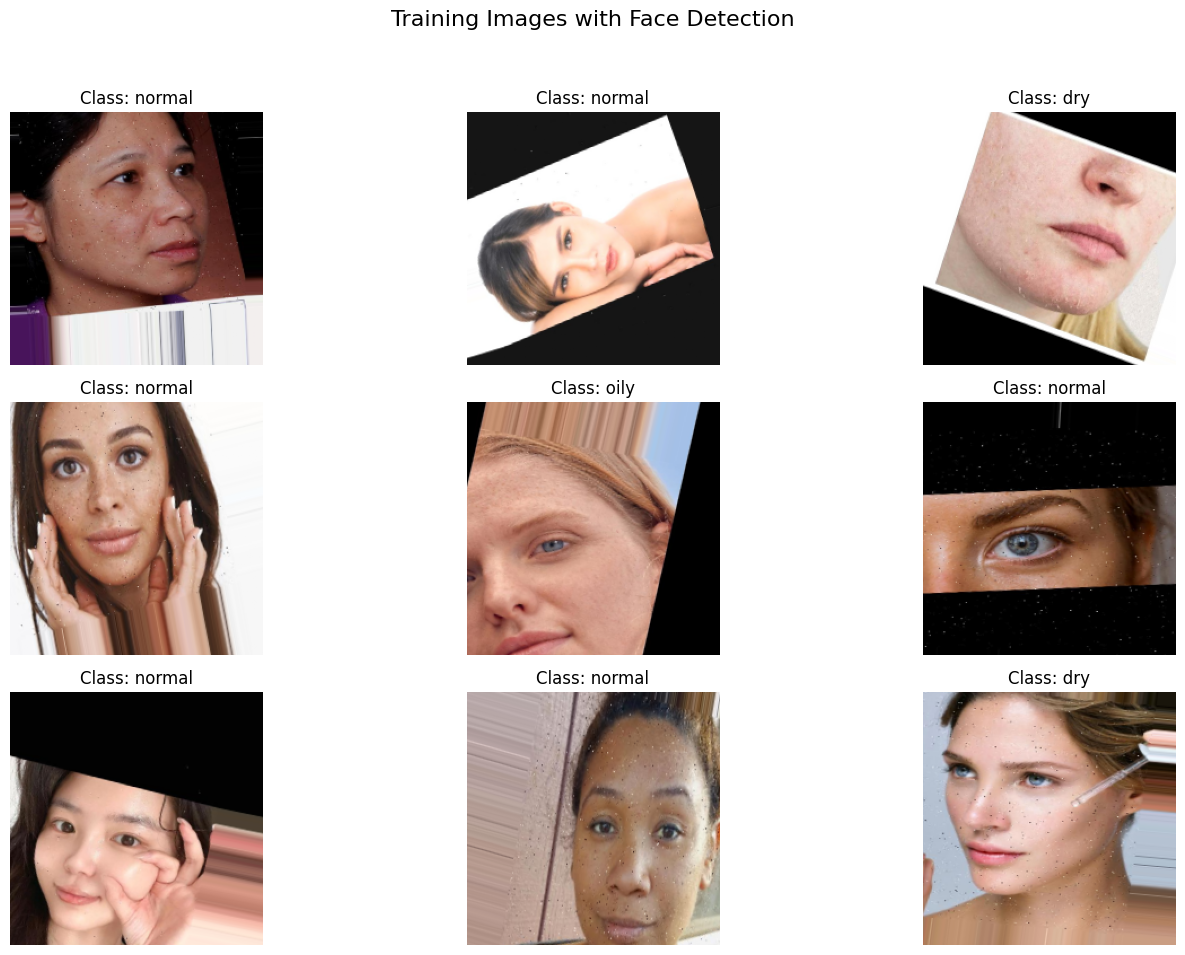

In [21]:
# Cell 8: Set Up Enhanced Data Generators with Face Detection
# Create data generators with face detection
train_generator_with_faces = FaceDetectionSequence(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=True,
    augment=True
)

validation_generator_with_faces = FaceDetectionSequence(
    directory=VAL_DIR,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=False,
    augment=False
)

test_generator_with_faces = FaceDetectionSequence(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    shuffle=False,
    augment=False
)

# Display a batch of processed images
def display_face_detection_batch(generator, title):
    """
    Display a batch of images from a face detection generator.
    """
    # Get a batch
    x_batch, y_batch = generator[0]

    # Create a figure
    plt.figure(figsize=(15, 10))
    plt.suptitle(title, fontsize=16)

    # Display up to 9 images
    num_images = min(9, len(x_batch))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])

        # Get class name
        class_idx = np.argmax(y_batch[i])
        class_name = generator.class_names[class_idx]

        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display a batch of processed images
display_face_detection_batch(train_generator_with_faces, 'Training Images with Face Detection')

Total test images analyzed: 134
Face detection success rate: 64.93%

Face detection by class:
  dry: 21/35 (60.00%)
  normal: 40/59 (67.80%)
  oily: 26/40 (65.00%)


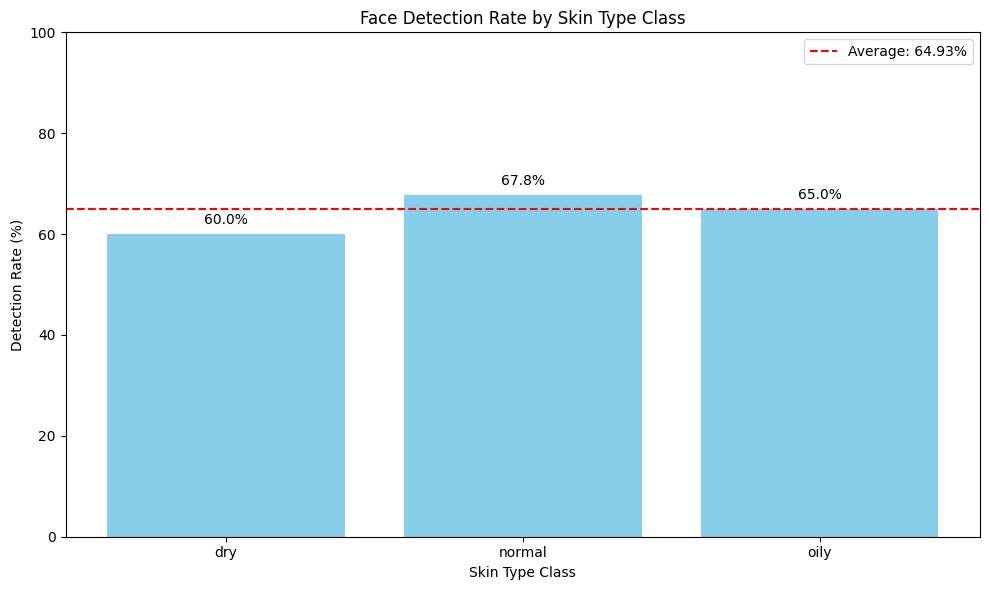


Samples where face detection succeeded:


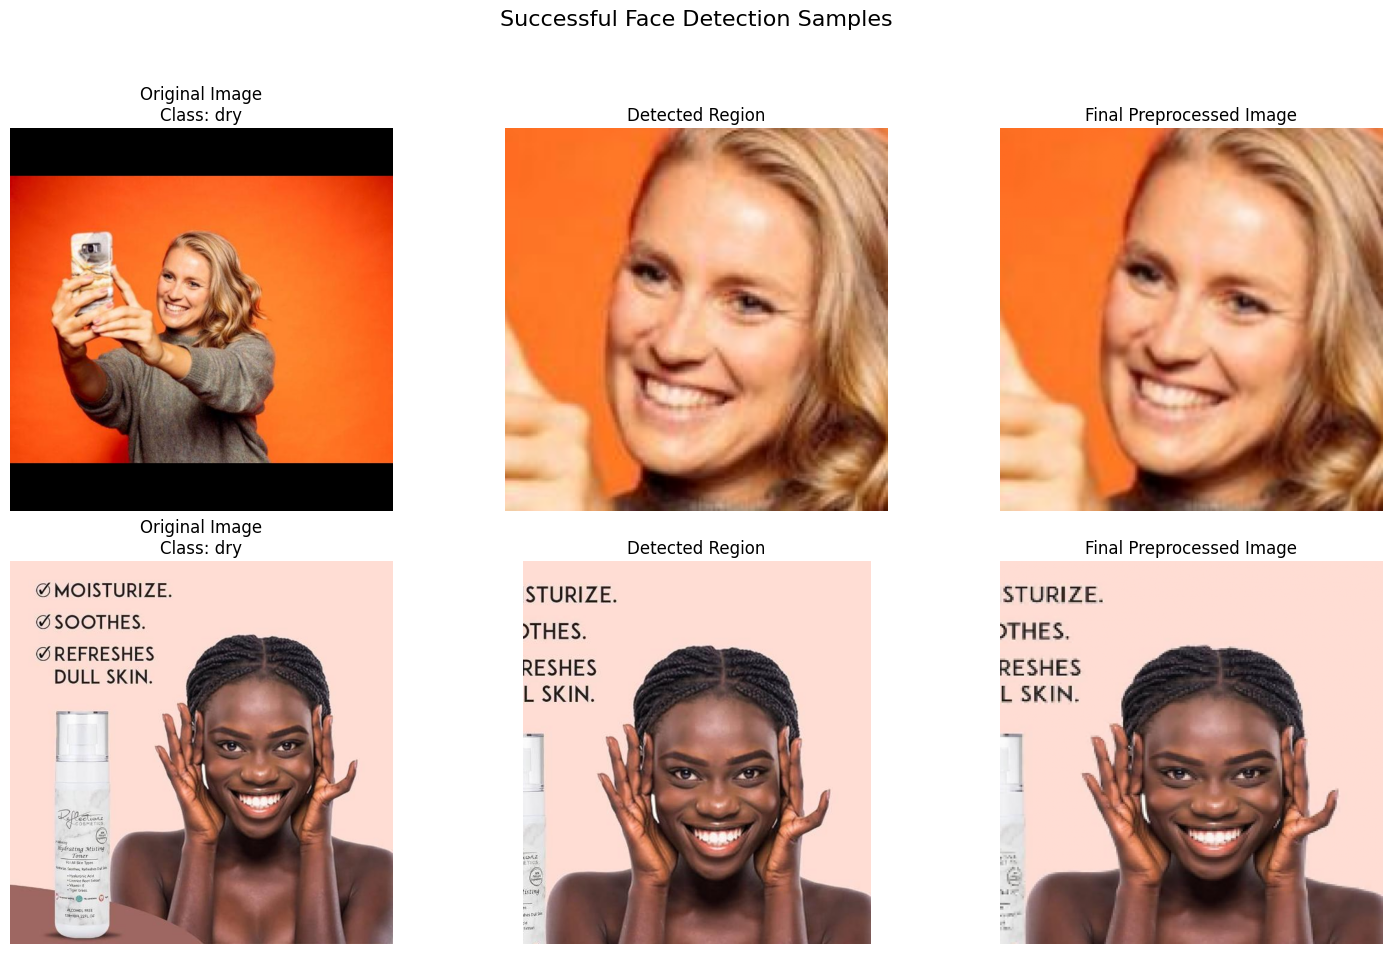


Samples where face detection failed:


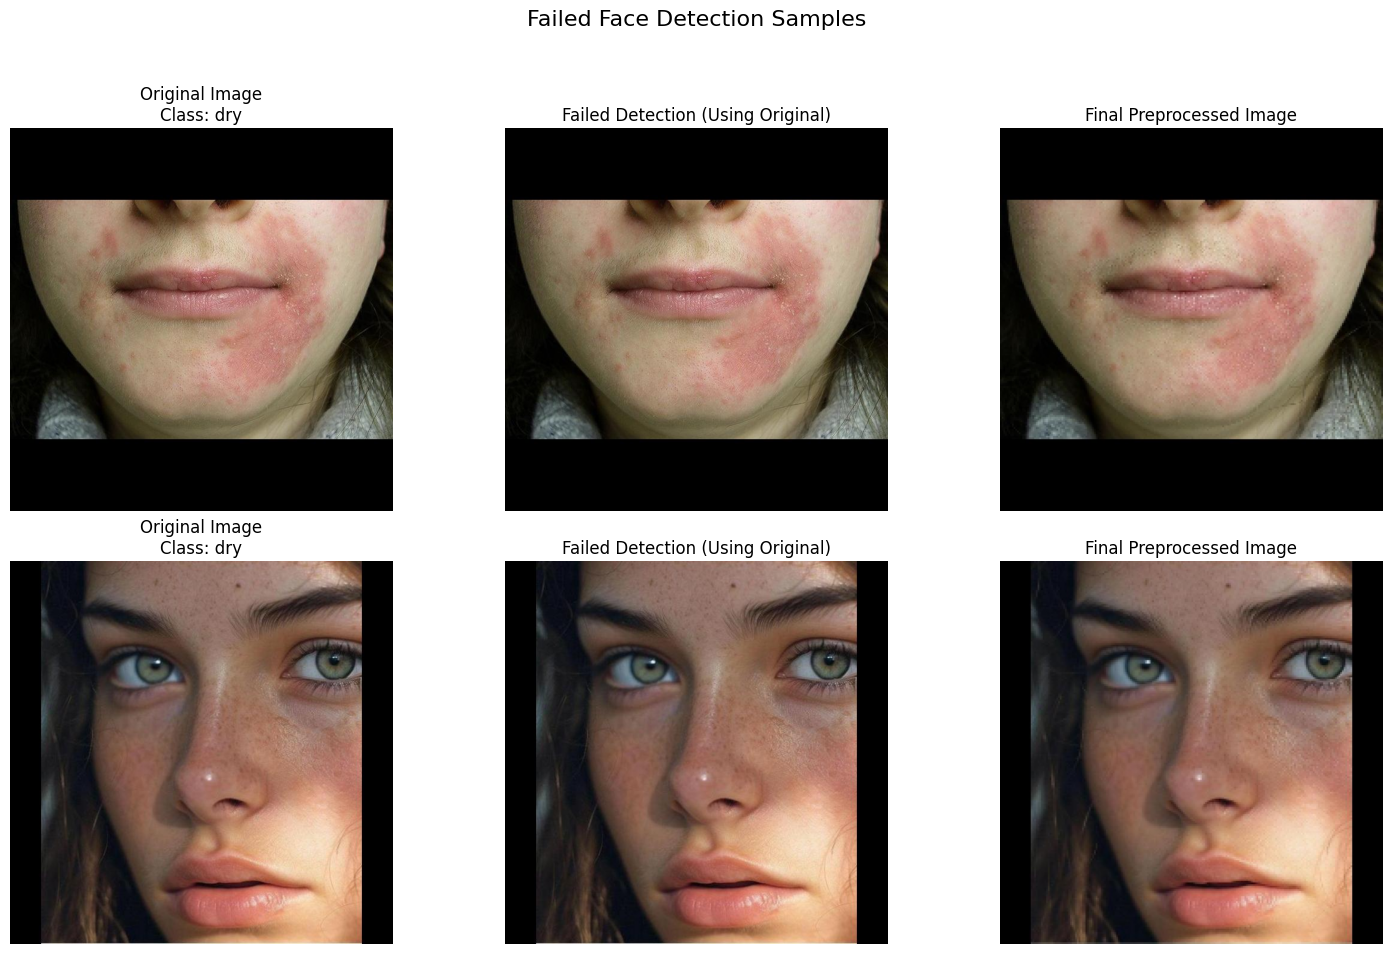

In [22]:
# Cell 9: Evaluate Face Detection Impact (Without Training History)
# Since we don't have training history yet, let's analyze the impact of face detection on the test set

# First, let's calculate face detection stats on the test set
face_detected_count = 0
total_images = 0
face_detection_by_class = {class_name: {'detected': 0, 'total': 0} for class_name in class_indices.keys()}

# Process test images
all_test_images = []
for class_name in class_indices.keys():
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
        for img_name in image_files:
            img_path = os.path.join(class_dir, img_name)
            all_test_images.append((img_path, class_name))

            # Process the image
            try:
                # Check if face is detected
                img = cv2.imread(img_path)
                _, face_detected = detect_face_improved(img)

                # Update stats
                total_images += 1
                face_detection_by_class[class_name]['total'] += 1

                if face_detected:
                    face_detected_count += 1
                    face_detection_by_class[class_name]['detected'] += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

# Calculate percentages
face_detection_rate = face_detected_count / total_images * 100 if total_images > 0 else 0
class_detection_rates = {}
for class_name, stats in face_detection_by_class.items():
    if stats['total'] > 0:
        detection_rate = stats['detected'] / stats['total'] * 100
        class_detection_rates[class_name] = detection_rate

# Print stats
print(f"Total test images analyzed: {total_images}")
print(f"Face detection success rate: {face_detection_rate:.2f}%")
print("\nFace detection by class:")
for class_name, rate in class_detection_rates.items():
    detected = face_detection_by_class[class_name]['detected']
    total = face_detection_by_class[class_name]['total']
    print(f"  {class_name}: {detected}/{total} ({rate:.2f}%)")

# Plot face detection rates by class
plt.figure(figsize=(10, 6))
plt.bar(class_detection_rates.keys(), class_detection_rates.values(), color='skyblue')
plt.axhline(y=face_detection_rate, color='r', linestyle='--', label=f'Average: {face_detection_rate:.2f}%')
plt.title('Face Detection Rate by Skin Type Class')
plt.ylabel('Detection Rate (%)')
plt.xlabel('Skin Type Class')
plt.ylim(0, 100)
plt.legend()

for i, (class_name, rate) in enumerate(class_detection_rates.items()):
    plt.text(i, rate + 2, f"{rate:.1f}%", ha='center')

plt.tight_layout()
plt.show()

# Show sample images with and without face detection
def display_face_detection_samples(with_face=True, num_samples=3):
    """
    Display sample images where face detection succeeded or failed.

    Args:
        with_face: If True, show samples where face detection succeeded, otherwise show failures
        num_samples: Number of samples to display
    """
    # Collect samples based on face detection status
    samples = []
    for img_path, class_name in all_test_images:
        try:
            img = cv2.imread(img_path)
            _, face_detected = detect_face_improved(img)

            if face_detected == with_face:
                samples.append((img_path, class_name))
                if len(samples) >= num_samples:
                    break
        except:
            continue

    if not samples:
        print(f"No samples found where face detection {'succeeded' if with_face else 'failed'}")
        return

    # Display samples
    plt.figure(figsize=(15, 5*len(samples)))
    status = "Successful" if with_face else "Failed"
    plt.suptitle(f"{status} Face Detection Samples", fontsize=16)

    for i, (img_path, class_name) in enumerate(samples):
        # Original image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detected region
        face_img, face_detected = detect_face_improved(img)
        face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)

        # Final processed image
        preprocessed, _ = preprocess_image_improved(img_path)

        # Display
        plt.subplot(len(samples), 3, i*3+1)
        plt.imshow(img_rgb)
        plt.title(f"Original Image\nClass: {class_name}")
        plt.axis('off')

        plt.subplot(len(samples), 3, i*3+2)
        plt.imshow(face_rgb)
        plt.title("Detected Region" if with_face else "Failed Detection (Using Original)")
        plt.axis('off')

        plt.subplot(len(samples), 3, i*3+3)
        plt.imshow(preprocessed)
        plt.title("Final Preprocessed Image")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display samples where face detection succeeded
print("\nSamples where face detection succeeded:")
display_face_detection_samples(with_face=True, num_samples=2)

# Display samples where face detection failed
print("\nSamples where face detection failed:")
display_face_detection_samples(with_face=False, num_samples=2)

NameError: name 'history_with_faces' is not defined

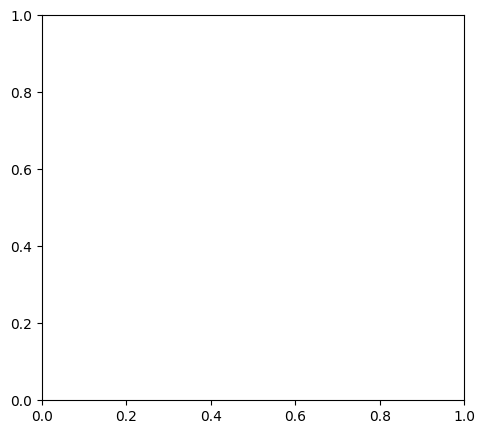

In [24]:
# Cell 10: Visualize Training History with Face Detection
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_with_faces.history['accuracy'])
plt.plot(history_with_faces.history['val_accuracy'])
plt.title('Model Accuracy with Face Detection')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_with_faces.history['loss'])
plt.plot(history_with_faces.history['val_loss'])
plt.title('Model Loss with Face Detection')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 11: Evaluate Model with Face Detection on Test Data
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on test data with face detection
test_loss, test_accuracy = skin_type_model.evaluate(test_generator_with_faces, verbose=1)
print(f"Test Loss with Face Detection: {test_loss:.4f}")
print(f"Test Accuracy with Face Detection: {test_accuracy:.4f}")

# Get predictions for test data
# We need to collect all test data and predictions manually since we're using a custom generator
all_test_images = []
true_labels = []

# Collect all test image paths and true labels
for class_name in class_indices.keys():
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        class_idx = class_indices[class_name]
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith('.jpg'):
                img_path = os.path.join(class_dir, img_name)
                all_test_images.append(img_path)
                true_labels.append(class_idx)

# Make predictions
y_true = np.array(true_labels)
y_pred_probs = []
y_pred = []
face_detected_count = 0
face_detection_results = []

for img_path in all_test_images:
    # Preprocess with face detection
    img, face_detected = preprocess_image_improved(img_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Track face detection success
    if face_detected:
        face_detected_count += 1

    # Make prediction
    prediction = skin_type_model.predict(img, verbose=0)[0]
    y_pred_probs.append(prediction)
    predicted_class = np.argmax(prediction)
    y_pred.append(predicted_class)

    # Store face detection result
    face_detection_results.append({
        'image': os.path.basename(img_path),
        'true_class': list(class_indices.keys())[true_labels[len(y_pred)-1]],
        'predicted_class': list(class_indices.keys())[predicted_class],
        'face_detected': face_detected,
        'correct': predicted_class == true_labels[len(y_pred)-1]
    })

y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)

# Print face detection stats
print(f"Face detection success rate: {face_detected_count}/{len(all_test_images)} ({face_detected_count/len(all_test_images)*100:.2f}%)")

# Generate classification report
class_labels = list(class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:")
print(report)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix with Face Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Analyze impact of face detection on accuracy
face_detect_df = pd.DataFrame(face_detection_results)
accuracy_with_face = face_detect_df[face_detect_df['face_detected']]['correct'].mean()
accuracy_without_face = face_detect_df[~face_detect_df['face_detected']]['correct'].mean()

print(f"Accuracy when face detected: {accuracy_with_face:.4f}")
print(f"Accuracy when face not detected: {accuracy_without_face:.4f}")

# Plot accuracy by face detection
plt.figure(figsize=(8, 6))
face_groups = face_detect_df.groupby('face_detected')['correct'].mean()
face_counts = face_detect_df.groupby('face_detected').size()

plt.bar(['Face Not Detected', 'Face Detected'],
        [face_groups.get(False, 0), face_groups.get(True, 0)],
        color=['lightcoral', 'lightgreen'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy by Face Detection Status')

# Add count annotations
plt.text(0, face_groups.get(False, 0) + 0.02, f"n={face_counts.get(False, 0)}",
         ha='center', va='bottom')
plt.text(1, face_groups.get(True, 0) + 0.02, f"n={face_counts.get(True, 0)}",
         ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 12: Visualize Training History
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Evaluate Model with Face Detection on Test Data
def evaluate_model_with_face_detection():
    """
    Evaluate the model on test data using face detection preprocessing.

    Returns:
        Tuple of (y_true, y_pred, y_pred_probs)
    """
    # Get all test image paths and true labels
    y_true = []
    image_paths = []

    for class_name in class_indices.keys():
        class_dir = os.path.join(TEST_DIR, class_name)
        if os.path.exists(class_dir):
            class_idx = class_indices[class_name]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    y_true.append(class_idx)

    # Prepare to store predictions
    y_pred = []
    y_pred_probs = []
    face_detected_count = 0

    # Process each image
    for img_path in image_paths:
        try:
            # Preprocess image with face detection
            img, face_detected = preprocess_image_improved(img_path)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Count images where face was detected
            if face_detected:
                face_detected_count += 1

            # Make prediction
            pred_probs = skin_type_model.predict(img, verbose=0)[0]
            pred_class = np.argmax(pred_probs)

            # Store results
            y_pred.append(pred_class)
            y_pred_probs.append(pred_probs)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            # If error, use most common class as prediction
            y_pred.append(np.argmax(np.bincount(y_true)))
            y_pred_probs.append(np.zeros(len(class_indices)))

    print(f"Face detection success rate: {face_detected_count}/{len(image_paths)} ({face_detected_count/len(image_paths)*100:.2f}%)")

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred, y_pred_probs

# Evaluate model
print("Evaluating model with face detection...")
y_true, y_pred, y_pred_probs = evaluate_model_with_face_detection()

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)
print(f"Test Accuracy with Face Detection: {accuracy:.4f}")

# Generate classification report
class_labels = list(class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:")
print(report)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix with Face Detection')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 14: Save the Model
# Save the model in H5 format
final_model_path = os.path.join(OUTPUT_DIR, "skin_type_model_facedetection.h5")
skin_type_model.save(final_model_path)
print(f"Model saved to {final_model_path}")

# Save the model in TensorFlow SavedModel format
savedmodel_path = os.path.join(OUTPUT_DIR, "skin_type_model_facedetection_savedmodel")
skin_type_model.save(savedmodel_path)
print(f"Model also saved in TensorFlow SavedModel format to {savedmodel_path}")

# Save model metadata as JSON
import json
model_metadata = {
    "model_name": "skin_type_classifier_with_facedetection",
    "version": "1.0",
    "input_shape": [IMG_SIZE, IMG_SIZE, 3],
    "classes": CLASS_NAMES,
    "class_indices": class_indices,
    "base_model": "MobileNetV2",
    "preprocessing": "face_detection_with_center_crop_fallback",
    "trained_on": {
        "total_images": FaceDetectionImageDataGenerator(
            train_datagen, TRAIN_DIR, (IMG_SIZE, IMG_SIZE), BATCH_SIZE, 'categorical'
        ).samples,
        "epochs": len(history.history['accuracy']),
        "final_accuracy": history.history['accuracy'][-1],
        "final_val_accuracy": history.history['val_accuracy'][-1]
    }
}

metadata_path = os.path.join(OUTPUT_DIR, "skin_type_model_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=4)
print(f"Model metadata saved to {metadata_path}")

# Print a summary of the saved model information
print("\nModel Save Summary:")
print(f"- Model Type: Skin Type Classifier with Face Detection")
print(f"- Base Architecture: MobileNetV2")
print(f"- Input Shape: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"- Classes: {', '.join(CLASS_NAMES)}")
print(f"- Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"- Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"- Test Accuracy: {accuracy:.4f}")
print(f"- Save Locations:")
print(f"  - H5 Model: {final_model_path}")
print(f"  - SavedModel: {savedmodel_path}")
print(f"  - Metadata: {metadata_path}")